In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print("Cuda is not available.Training on CPU..")
else:
    print("Cuda is available.Training on GPU")

Cuda is available.Training on GPU


# Loading Data

In [3]:
def get_Dataloader(is_train = True,batch_size = 20):
    if is_train:
        transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.RandomRotation(10),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
        transform_validation = transforms.Compose([transforms.ToTensor(),
                                           transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
        train_data = datasets.CIFAR100('Data',train = True, download = True,transform = transform_train)
        size = len(train_data)
        indices = list(range(size))
        np.random.shuffle(indices)
        split =  int(np.floor(0.2 * size))
        train_idx,val_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, sampler = train_sampler, num_workers = 0)
        val_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, sampler = val_sampler, num_workers = 0)
        return train_loader, val_loader
    else:
        transform_test = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
        test_data = datasets.CIFAR100('Data',train = False, download = False,transform = transform_test)
        test_loader = torch.utils.data.DataLoader(test_data,batch_size = batch_size, num_workers = 0)
    
        return test_loader

In [4]:
train_loader,val_loader = get_Dataloader()
test_loader = get_Dataloader(is_train = False)
print(len(train_loader),len(val_loader),len(test_loader))

Files already downloaded and verified
2000 500 500


In [5]:
def conv(in_channels, out_channels, kernel_size, stride=1, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)


# Visualizing the data

In [6]:
def imshow(image):
    image = image/2 + 0.5 #un-normalizing
    plt.imshow(np.transpose(image,(1,2,0)))

classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm']

torch.Size([20])


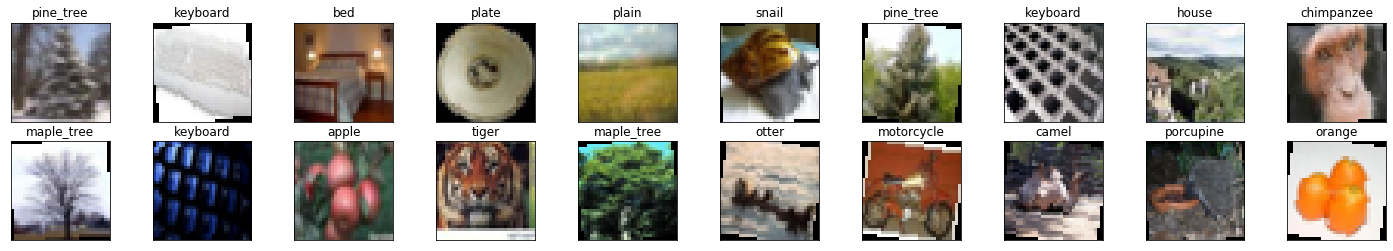

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
print(labels.shape)
fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx+1,xticks =[],yticks =[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

0.9607843
0.90588236
0.88235295


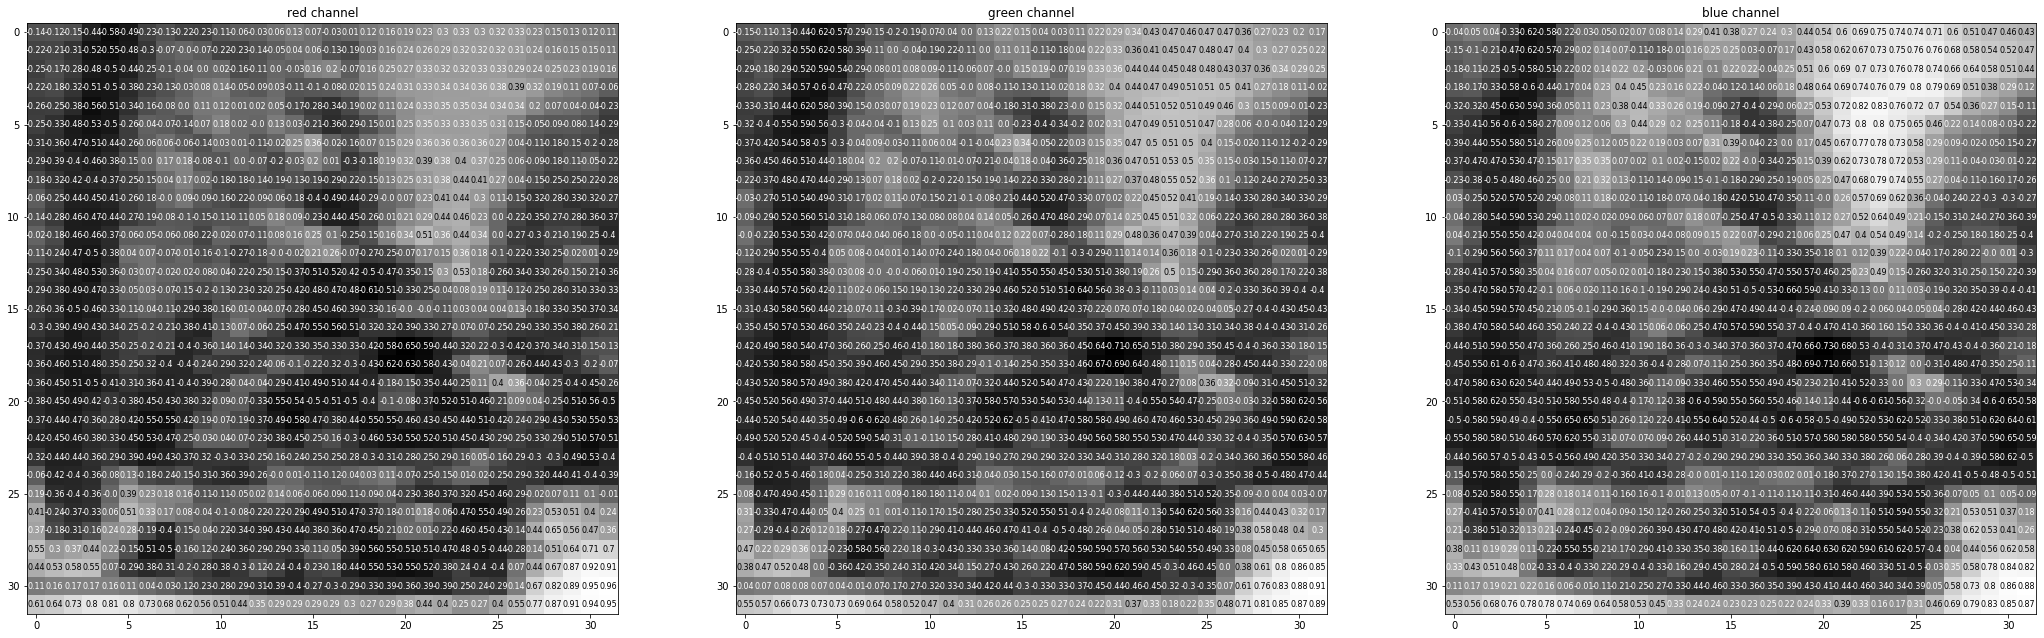

In [8]:
rgb_img = np.squeeze(images[0])
channel = ['red channel', 'green channel', 'blue channel']
fig = plt.figure(figsize =(36,36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1,3,idx+1)
    img = rgb_img[idx]
    ax.imshow(img,cmap ='gray')
    ax.set_title(channel[idx])
    width,height = img.shape
    print(img.max())
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] != 0 else 0
            ax.annotate(str(val),xy =(y,x),horizontalalignment ='center',verticalalignment ='center',size = 8,color = 'white' if img[x][y]<thresh else 'black')

# Training on dataset(a)

In [9]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        
        self.conv1 = conv(3,64,3)
        self.conv2 = conv(64,128,3)
        self.conv3 = conv(128,256,3)
        self.conv4 = conv(256,512,3)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(512*2*2,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,100)
        self.drop = nn.Dropout(.2)
    
    def forward(self,x):
        
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.pool(F.elu(self.conv4(x)))
        x = x.view(-1,512*2*2)
        x = self.drop(x)
        x = self.drop(self.fc1(x))
        
        x = self.drop(self.fc2(x))
        x = self.fc3(x)
        return x
    
network = Network()
print(network)
        
if train_on_gpu:
    network.cuda()

Network(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_feat

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(),lr= 0.002)

In [11]:
import time
print ("Start Execution : ",end="") 
start_time = time.ctime()
print(start_time) 
epochs = 100
val_loss_min = np.Inf
for e in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    network.train()
    for images,labels in train_loader:
        
        if train_on_gpu:
            images,labels = images.cuda(),labels.cuda()
        
        optimizer.zero_grad()
        output = network.forward(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()*images.size(0)
    
    network.eval()
    for images,labels in val_loader:
        
        if train_on_gpu:
            images,labels = images.cuda(),labels.cuda()
        
        output = network.forward(images)
        loss = criterion(output,labels)
        valid_loss += loss.item()*images.size(0)
        
    training_loss = training_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)
    
    print('Epoch : {} \tTraining Loss : {: .4f} \tValidation Loss : {: .4f}'.format(e+1,training_loss,valid_loss))
    
    if valid_loss <= val_loss_min:
        print('Validation Loss decreased ({: .4f} ---> {: .4f}. Saving Model)'.format(val_loss_min,valid_loss))
        torch.save(network.state_dict(),'model_detail.pt')
        val_loss_min = valid_loss
print ("Stop Execution : ",end="") 
end_time = time.ctime()
print(end_time) 

Start Execution : Mon Sep 16 23:05:39 2019
Epoch : 1 	Training Loss :  4.2415 	Validation Loss :  3.9146
Validation Loss decreased ( inf --->  3.9146. Saving Model)
Epoch : 2 	Training Loss :  3.7571 	Validation Loss :  3.5573
Validation Loss decreased ( 3.9146 --->  3.5573. Saving Model)
Epoch : 3 	Training Loss :  3.4758 	Validation Loss :  3.3053
Validation Loss decreased ( 3.5573 --->  3.3053. Saving Model)
Epoch : 4 	Training Loss :  3.2693 	Validation Loss :  3.1175
Validation Loss decreased ( 3.3053 --->  3.1175. Saving Model)
Epoch : 5 	Training Loss :  3.0847 	Validation Loss :  2.9670
Validation Loss decreased ( 3.1175 --->  2.9670. Saving Model)
Epoch : 6 	Training Loss :  2.9274 	Validation Loss :  2.8353
Validation Loss decreased ( 2.9670 --->  2.8353. Saving Model)
Epoch : 7 	Training Loss :  2.8095 	Validation Loss :  2.7171
Validation Loss decreased ( 2.8353 --->  2.7171. Saving Model)
Epoch : 8 	Training Loss :  2.7074 	Validation Loss :  2.6206
Validation Loss decreas

Epoch : 92 	Training Loss :  0.8663 	Validation Loss :  1.8534
Epoch : 93 	Training Loss :  0.8533 	Validation Loss :  1.8401
Epoch : 94 	Training Loss :  0.8366 	Validation Loss :  1.8609
Epoch : 95 	Training Loss :  0.8261 	Validation Loss :  1.8565
Epoch : 96 	Training Loss :  0.8149 	Validation Loss :  1.8846
Epoch : 97 	Training Loss :  0.8133 	Validation Loss :  1.9039
Epoch : 98 	Training Loss :  0.7939 	Validation Loss :  1.8674
Epoch : 99 	Training Loss :  0.7978 	Validation Loss :  1.9438
Epoch : 100 	Training Loss :  0.7881 	Validation Loss :  1.9066
Stop Execution : Mon Sep 16 23:58:11 2019


# Testing dataset

In [12]:
network.load_state_dict(torch.load('model_detail.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [13]:
print ("Start Execution : ",end="") 
start_time_test = time.ctime()
print(start_time_test) 
test_loss = 0.0
batch_size = 20
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
network.eval()
for images,labels in test_loader:
    
    if train_on_gpu:
        images,labels = images.cuda(),labels.cuda()
    output = network.forward(images)
    loss = criterion(output,labels)
    test_loss += loss.item()*images.size(0)
    _,pred = torch.max(output, 1)
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(batch_size):
        target = labels.data[i]
        class_correct[target] += correct[i].item()
        class_total[target] += 1
        
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.4f}\n'.format(test_loss))
for i in range(100):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
print ("Stop Execution : ",end="") 
end_time_test = time.ctime()
print(end_time_test) 

Start Execution : Mon Sep 16 23:58:11 2019
Test Loss: 1.7115

Test Accuracy of apple: 66% (66/100)
Test Accuracy of aquarium_fish: 64% (64/100)
Test Accuracy of  baby: 42% (42/100)
Test Accuracy of  bear: 25% (25/100)
Test Accuracy of beaver: 37% (37/100)
Test Accuracy of   bed: 62% (62/100)
Test Accuracy of   bee: 64% (64/100)
Test Accuracy of beetle: 52% (52/100)
Test Accuracy of bicycle: 69% (69/100)
Test Accuracy of bottle: 74% (74/100)
Test Accuracy of  bowl: 32% (32/100)
Test Accuracy of   boy: 30% (30/100)
Test Accuracy of bridge: 61% (61/100)
Test Accuracy of   bus: 46% (46/100)
Test Accuracy of butterfly: 60% (60/100)
Test Accuracy of camel: 39% (39/100)
Test Accuracy of   can: 56% (56/100)
Test Accuracy of castle: 76% (76/100)
Test Accuracy of caterpillar: 38% (38/100)
Test Accuracy of cattle: 42% (42/100)
Test Accuracy of chair: 80% (80/100)
Test Accuracy of chimpanzee: 78% (78/100)
Test Accuracy of clock: 45% (45/100)
Test Accuracy of cloud: 70% (70/100)
Test Accuracy of co

# Training the dataset(b) .499x computation model

In [14]:
class Network_1(nn.Module):
    def __init__(self):
        super(Network_1,self).__init__()
        
        self.conv1 = conv(3,32,3)
        self.conv2 = conv(32,64,3)
        self.conv3 = conv(64,128,3)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(128*4*4,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,100)
        self.drop = nn.Dropout(.2)
    
    def forward(self,x):
        
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x)))
        x = x.view(-1,128*4*4)
        x = self.drop(x)
        x = self.drop(self.fc1(x))
        
        x = self.drop(self.fc2(x))
        x = self.fc3(x)
        return x
    
network_1 = Network_1()
print(network_1)
        
if train_on_gpu:
    network_1.cuda()

Network_1(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=100, bias=True)
  (drop): Dropout(p=0.2)
)


In [15]:

criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(network_1.parameters(),lr= 0.002)

In [16]:
import time
print ("Start Execution : ",end="") 
start_time_1 = time.ctime()
print(start_time_1) 
epochs = 100
val_loss_min = np.Inf
for e in range(epochs):
    training_loss_1 = 0.0
    valid_loss_1 = 0.0
    network_1.train()
    for images,labels in train_loader:
        
        if train_on_gpu:
            images,labels = images.cuda(),labels.cuda()
        
        optimizer_1.zero_grad()
        output = network_1.forward(images)
        loss = criterion_1(output,labels)
        loss.backward()
        optimizer_1.step()
        training_loss_1 += loss.item()*images.size(0)
    
    network_1.eval()
    for images,labels in val_loader:
        
        if train_on_gpu:
            images,labels = images.cuda(),labels.cuda()
        
        output = network_1.forward(images)
        loss = criterion_1(output,labels)
        valid_loss_1 += loss.item()*images.size(0)
        
    training_loss_1 = training_loss_1/len(train_loader.sampler)
    valid_loss_1 = valid_loss_1/len(val_loader.sampler)
    
    print('Epoch : {} \tTraining Loss : {: .4f} \tValidation Loss : {: .4f}'.format(e+1,training_loss_1,valid_loss_1))
    
    if valid_loss_1 <= val_loss_min:
        print('Validation Loss decreased ({: .4f} ---> {: .4f}. Saving Model)'.format(val_loss_min,valid_loss_1))
        torch.save(network_1.state_dict(),'model_detail_1.pt')
        val_loss_min = valid_loss_1
print ("Stop Execution : ",end="") 
end_time_1 = time.ctime()
print(end_time_1) 

Start Execution : Mon Sep 16 23:58:15 2019
Epoch : 1 	Training Loss :  4.3784 	Validation Loss :  4.0992
Validation Loss decreased ( inf --->  4.0992. Saving Model)
Epoch : 2 	Training Loss :  3.9586 	Validation Loss :  3.7461
Validation Loss decreased ( 4.0992 --->  3.7461. Saving Model)
Epoch : 3 	Training Loss :  3.6969 	Validation Loss :  3.5360
Validation Loss decreased ( 3.7461 --->  3.5360. Saving Model)
Epoch : 4 	Training Loss :  3.5306 	Validation Loss :  3.3939
Validation Loss decreased ( 3.5360 --->  3.3939. Saving Model)
Epoch : 5 	Training Loss :  3.3919 	Validation Loss :  3.2606
Validation Loss decreased ( 3.3939 --->  3.2606. Saving Model)
Epoch : 6 	Training Loss :  3.2736 	Validation Loss :  3.1479
Validation Loss decreased ( 3.2606 --->  3.1479. Saving Model)
Epoch : 7 	Training Loss :  3.1595 	Validation Loss :  3.0421
Validation Loss decreased ( 3.1479 --->  3.0421. Saving Model)
Epoch : 8 	Training Loss :  3.0648 	Validation Loss :  2.9437
Validation Loss decreas

Epoch : 78 	Training Loss :  1.8545 	Validation Loss :  1.9302
Validation Loss decreased ( 1.9367 --->  1.9302. Saving Model)
Epoch : 79 	Training Loss :  1.8393 	Validation Loss :  1.9430
Epoch : 80 	Training Loss :  1.8427 	Validation Loss :  1.9155
Validation Loss decreased ( 1.9302 --->  1.9155. Saving Model)
Epoch : 81 	Training Loss :  1.8419 	Validation Loss :  1.9339
Epoch : 82 	Training Loss :  1.8251 	Validation Loss :  1.9185
Epoch : 83 	Training Loss :  1.8248 	Validation Loss :  1.9121
Validation Loss decreased ( 1.9155 --->  1.9121. Saving Model)
Epoch : 84 	Training Loss :  1.8145 	Validation Loss :  1.9151
Epoch : 85 	Training Loss :  1.8022 	Validation Loss :  1.8986
Validation Loss decreased ( 1.9121 --->  1.8986. Saving Model)
Epoch : 86 	Training Loss :  1.8093 	Validation Loss :  1.9016
Epoch : 87 	Training Loss :  1.7968 	Validation Loss :  1.8932
Validation Loss decreased ( 1.8986 --->  1.8932. Saving Model)
Epoch : 88 	Training Loss :  1.7898 	Validation Loss : 

In [17]:
network_1.load_state_dict(torch.load('model_detail_1.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Testing dataset

In [18]:
print ("Start Execution : ",end="") 
start_time_test_1 = time.ctime()
print(start_time_test_1) 
test_loss_1 = 0.0
batch_size = 20
class_correct_1 = list(0. for i in range(100))
class_total_1 = list(0. for i in range(100))
network_1.eval()
for images,labels in test_loader:
    
    if train_on_gpu:
        images,labels = images.cuda(),labels.cuda()
    output = network_1.forward(images)
    loss = criterion_1(output,labels)
    test_loss_1 += loss.item()*images.size(0)
    _,pred = torch.max(output, 1)
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(batch_size):
        target = labels.data[i]
        class_correct_1[target] += correct[i].item()
        class_total_1[target] += 1
        
test_loss_1 = test_loss_1/len(test_loader.dataset)
print('Test Loss: {:.4f}\n'.format(test_loss_1))
for i in range(100):
    if class_total_1[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct_1[i] / class_total_1[i],
            np.sum(class_correct_1[i]), np.sum(class_total_1[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct_1) / np.sum(class_total_1),
    np.sum(class_correct_1), np.sum(class_total_1)))
print ("Stop Execution : ",end="") 
end_time_test_1 = time.ctime()
print(end_time_test_1) 

Start Execution : Tue Sep 17 00:28:46 2019
Test Loss: 1.7810

Test Accuracy of apple: 76% (76/100)
Test Accuracy of aquarium_fish: 75% (75/100)
Test Accuracy of  baby: 37% (37/100)
Test Accuracy of  bear: 28% (28/100)
Test Accuracy of beaver: 35% (35/100)
Test Accuracy of   bed: 57% (57/100)
Test Accuracy of   bee: 68% (68/100)
Test Accuracy of beetle: 52% (52/100)
Test Accuracy of bicycle: 71% (71/100)
Test Accuracy of bottle: 63% (63/100)
Test Accuracy of  bowl: 34% (34/100)
Test Accuracy of   boy: 28% (28/100)
Test Accuracy of bridge: 55% (55/100)
Test Accuracy of   bus: 48% (48/100)
Test Accuracy of butterfly: 48% (48/100)
Test Accuracy of camel: 40% (40/100)
Test Accuracy of   can: 49% (49/100)
Test Accuracy of castle: 81% (81/100)
Test Accuracy of caterpillar: 43% (43/100)
Test Accuracy of cattle: 38% (38/100)
Test Accuracy of chair: 71% (71/100)
Test Accuracy of chimpanzee: 66% (66/100)
Test Accuracy of clock: 47% (47/100)
Test Accuracy of cloud: 65% (65/100)
Test Accuracy of co

# Training the dataset(c) results of (a) as the ground truth

In [19]:
network_11 = Network_1()
print(network_11)
        
if train_on_gpu:
    network_11.cuda()

Network_1(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=100, bias=True)
  (drop): Dropout(p=0.2)
)


In [20]:

criterion_11 = nn.CrossEntropyLoss()
optimizer_11 = optim.SGD(network_11.parameters(),lr= 0.002)

In [21]:
print ("Start Execution : ",end="") 
start_time_11 = time.ctime()
print(start_time_11) 
epochs = 100
val_loss_min = np.Inf
for e in range(epochs):
    training_loss_11 = 0.0
    valid_loss_11 = 0.0
    network_11.train()
    for images,labels in train_loader:
        
        if train_on_gpu:
            images,labels = images.cuda(),labels.cuda()
            
        optimizer_11.zero_grad()
        output = network.forward(images)
        #print(output.shape)
        _,pred = torch.max(output, 1)
        correct_tensor = pred.data.view_as(labels)
        #print(correct_tensor.shape)
        output_11 = network_11.forward(images)
        loss = criterion_11(output_11,correct_tensor)
        loss.backward()
        optimizer_11.step()
        training_loss_11 += loss.item()*images.size(0)
    
    network_11.eval()
    for images,labels in val_loader:
        
        if train_on_gpu:
            images,labels = images.cuda(),labels.cuda()
        
        output = network.forward(images)
        #print(output.shape)
        _,pred = torch.max(output, 1)
        correct_tensor = pred.data.view_as(labels)
        #print(correct_tensor.shape)
        output_11 = network_11.forward(images)
        loss = criterion_11(output_11,correct_tensor)
        valid_loss_11 += loss.item()*images.size(0)
    
    training_loss_11 = training_loss_11/len(train_loader.sampler)
    valid_loss_11 = valid_loss_11/len(val_loader.sampler)
    
    print('Epoch : {} \tTraining Loss : {: .4f} \tValidation Loss : {: .4f}'.format(e+1,training_loss_11,valid_loss_11))
    
    if valid_loss_11 <= val_loss_min:
        print('Validation Loss decreased ({: .4f} ---> {: .4f}. Saving Model)'.format(val_loss_min,valid_loss_11))
        torch.save(network_11.state_dict(),'model_detail_11.pt')
        val_loss_min = valid_loss_11
print ("Stop Execution : ",end="") 
end_time_11 = time.ctime()
print(end_time_11) 
        

Start Execution : Tue Sep 17 00:28:49 2019
Epoch : 1 	Training Loss :  4.3643 	Validation Loss :  4.0203
Validation Loss decreased ( inf --->  4.0203. Saving Model)
Epoch : 2 	Training Loss :  3.9040 	Validation Loss :  3.5991
Validation Loss decreased ( 4.0203 --->  3.5991. Saving Model)
Epoch : 3 	Training Loss :  3.6047 	Validation Loss :  3.3522
Validation Loss decreased ( 3.5991 --->  3.3522. Saving Model)
Epoch : 4 	Training Loss :  3.3969 	Validation Loss :  3.1298
Validation Loss decreased ( 3.3522 --->  3.1298. Saving Model)
Epoch : 5 	Training Loss :  3.2321 	Validation Loss :  2.9619
Validation Loss decreased ( 3.1298 --->  2.9619. Saving Model)
Epoch : 6 	Training Loss :  3.0869 	Validation Loss :  2.7901
Validation Loss decreased ( 2.9619 --->  2.7901. Saving Model)
Epoch : 7 	Training Loss :  2.9672 	Validation Loss :  2.6641
Validation Loss decreased ( 2.7901 --->  2.6641. Saving Model)
Epoch : 8 	Training Loss :  2.8479 	Validation Loss :  2.5965
Validation Loss decreas

Epoch : 78 	Training Loss :  1.4739 	Validation Loss :  1.2805
Epoch : 79 	Training Loss :  1.4611 	Validation Loss :  1.2898
Epoch : 80 	Training Loss :  1.4681 	Validation Loss :  1.2478
Validation Loss decreased ( 1.2711 --->  1.2478. Saving Model)
Epoch : 81 	Training Loss :  1.4517 	Validation Loss :  1.2546
Epoch : 82 	Training Loss :  1.4452 	Validation Loss :  1.2632
Epoch : 83 	Training Loss :  1.4481 	Validation Loss :  1.2539
Epoch : 84 	Training Loss :  1.4420 	Validation Loss :  1.2683
Epoch : 85 	Training Loss :  1.4385 	Validation Loss :  1.2830
Epoch : 86 	Training Loss :  1.4211 	Validation Loss :  1.2348
Validation Loss decreased ( 1.2478 --->  1.2348. Saving Model)
Epoch : 87 	Training Loss :  1.4195 	Validation Loss :  1.2635
Epoch : 88 	Training Loss :  1.4164 	Validation Loss :  1.2329
Validation Loss decreased ( 1.2348 --->  1.2329. Saving Model)
Epoch : 89 	Training Loss :  1.4181 	Validation Loss :  1.2394
Epoch : 90 	Training Loss :  1.4124 	Validation Loss : 

# Testing dataset

In [22]:
print ("Start Execution : ",end="") 
start_time_test_11 = time.ctime()
print(start_time_test_11) 
test_loss_11 = 0.0
batch_size = 20
class_correct_11 = list(0. for i in range(100))
class_total_11 = list(0. for i in range(100))
network_11.eval()
for images,labels in test_loader:
    
    if train_on_gpu:
        images,labels = images.cuda(),labels.cuda()
    output = network.forward(images)
    #print(output.shape)
    _,pred = torch.max(output, 1)
    correct_tensor = pred.data.view_as(labels)
    output_11 = network_11.forward(images)
    loss = criterion_11(output_11,correct_tensor)
    test_loss_11 += loss.item()*images.size(0)
    _,pred_11 = torch.max(output_11, 1)
    correct_tensor_11 = pred_11.eq(correct_tensor.data.view_as(pred_11))
    correct = np.squeeze(correct_tensor_11.numpy()) if not train_on_gpu else np.squeeze(correct_tensor_11.cpu().numpy())
    
    for i in range(batch_size):
        target = labels.data[i]
        class_correct_11[target] += correct[i].item()
        class_total_11[target] += 1
        
test_loss_11 = test_loss_11/len(test_loader.dataset)
print('Test Loss: {:.4f}\n'.format(test_loss_11))
for i in range(100):
    if class_total_11[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct_11[i] / class_total_11[i],
            np.sum(class_correct_11[i]), np.sum(class_total_11[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct_11) / np.sum(class_total_11),
    np.sum(class_correct_11), np.sum(class_total_11)))
print ("Stop Execution : ",end="") 
end_time_test_11 = time.ctime()
print(end_time_test_11) 

Start Execution : Tue Sep 17 01:04:05 2019
Test Loss: 1.1816

Test Accuracy of apple: 75% (75/100)
Test Accuracy of aquarium_fish: 68% (68/100)
Test Accuracy of  baby: 53% (53/100)
Test Accuracy of  bear: 50% (50/100)
Test Accuracy of beaver: 47% (47/100)
Test Accuracy of   bed: 66% (66/100)
Test Accuracy of   bee: 64% (64/100)
Test Accuracy of beetle: 63% (63/100)
Test Accuracy of bicycle: 74% (74/100)
Test Accuracy of bottle: 79% (79/100)
Test Accuracy of  bowl: 56% (56/100)
Test Accuracy of   boy: 57% (57/100)
Test Accuracy of bridge: 72% (72/100)
Test Accuracy of   bus: 55% (55/100)
Test Accuracy of butterfly: 65% (65/100)
Test Accuracy of camel: 54% (54/100)
Test Accuracy of   can: 74% (74/100)
Test Accuracy of castle: 76% (76/100)
Test Accuracy of caterpillar: 53% (53/100)
Test Accuracy of cattle: 55% (55/100)
Test Accuracy of chair: 87% (87/100)
Test Accuracy of chimpanzee: 76% (76/100)
Test Accuracy of clock: 55% (55/100)
Test Accuracy of cloud: 78% (78/100)
Test Accuracy of co